Done 11.11111111111111 percent of calculations.
Done 22.22222222222222 percent of calculations.
Done 33.333333333333336 percent of calculations.
Done 44.44444444444444 percent of calculations.
Done 55.55555555555556 percent of calculations.
Done 66.66666666666667 percent of calculations.
Done 77.77777777777777 percent of calculations.
Done 88.88888888888889 percent of calculations.
Done 100.0 percent of calculations.


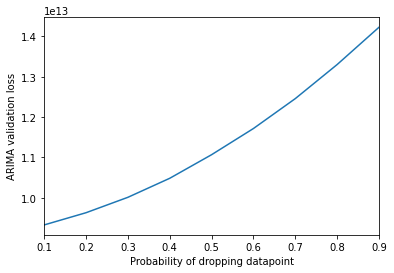

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import bernoulli
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.dates as mdates
import warnings
import matplotlib.pyplot as plt


warnings.simplefilter('ignore', np.RankWarning) # ignore RankWarning from polyfit
warnings.simplefilter('ignore', UserWarning) # ignore UserWarning from ARIMA

df = pd.read_csv("power_generation_processed.csv")
df = df.replace(0.0, 1.0)
df = df.replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(value=1)

X = df.pop("Timestamp")
y = df.pop("Solar PV")

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)

# print(f"No. of training examples: {training_data.shape[0]}")
# print(f"No. of testing examples: {testing_data.shape[0]}")

def prepare_dataset(df_timestamps):
    for i in range(len(df_timestamps)):
        value = int(df_timestamps[i][11:13])
        value -= 1
        value = "{:02d}".format(value)
        value = str(value)
        value = df_timestamps[i][0:11] + value
        df_timestamps[i] = value

    df_timestamps = pd.to_datetime(df_timestamps)
    df_timestamps = mdates.date2num(df_timestamps)

    return df_timestamps

x_train = prepare_dataset(x_train)
y_train = y_train.to_numpy()

r = list(map(lambda x: x/10.0, range(1, 10)))
n_trial_total = 50
vl = np.zeros(np.shape(r))

i = 0
for rcur in r:
    rcur_loss = 0
    count = 0
    for n_trial in range(n_trial_total):
        boole = bernoulli(rcur)
        dropped_index = boole.rvs(x_train.size)
        x_train_drp = x_train[dropped_index==1]
        y_train_drp = y_train[dropped_index==1]
        x_train_ret = x_train[dropped_index==0]
        y_train_ret = y_train[dropped_index==0]
        # now we find best polynomial degree for regression to filled dropped data points
        best_deg = np.inf
        best_loss = np.inf
        best_coeff = []
        for deg in range(20):
            # print(deg)
            # print(x_train_ret,y_train_ret)
            coeff = np.polyfit(x_train_ret,y_train_ret,deg)
            y_train_drp_pred = np.polyval(coeff,x_train_drp)
            cur_loss = np.sum((y_train_drp_pred-y_train_drp)**2)
            if cur_loss < best_loss:
                best_loss = cur_loss
                best_def = deg
                best_coeff = []
        # now we reconstruct the filled x and y training values
        x_train_filled = x_train
        y_train_filled = np.zeros(np.size(y_train))
        y_train_filled[dropped_index==0] = y_train_ret
        y_train_filled[dropped_index==1] = np.polyval(best_coeff,x_train_drp)
        # now we predict the time series (y-values) FORWARD with ARIMA
        model = ARIMA(y_train_filled,order = (1,0,1))
        model_fit = model.fit()
        y_test_pred = model_fit.predict(y_train_filled.size,y_train_filled.size+x_test.size-1)
        cur_loss_arima = np.sum((y_test_pred-y_test)**2)
        rcur_loss += cur_loss_arima
    count += 1
    rcur_loss /= count
    vl[i] = rcur_loss
    print('Done '+str((i+1)*100/len(r))+' percent of calculations.')
    i += 1

plt.plot(r,vl)
plt.xlim((min(r),max(r)))
plt.xlabel('Probability of dropping datapoint')
plt.ylabel('ARIMA validation loss')
plt.show()
